# Machine Learning Nanodegree Capstone Project 
## Leaf Classification - Kaggle Competition


In [8]:
# Extracting all images to the images folder

#import zipfile
#zipp = zipfile.ZipFile('images/images.zip')
#zipp.extractall()

### Starting with:
#### - Loading Python packages
#### - Loading tabular and image data,
#### - Data preprocessing
#### - Splitting training data into training and validation 

In [9]:
# import all required packages
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import seaborn as sns
from sklearn.datasets import load_files
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from keras.preprocessing import image

# setting random_state reduce result randomness
random_state = 123

# Loading source tabular data for training and testing
df_train = pd.read_csv('train.csv',index_col= 'id')
X_test_org = pd.read_csv('test.csv',index_col = 'id')

# Defining training features and labels
y_train = df_train["species"]
X_train_org = df_train.drop(["species"],axis = 1)

# Preprocessing training and testing data 
X_train = pd.DataFrame(MinMaxScaler().fit(X_train_org).transform(X_train_org),index=X_train_org.index,columns=X_train_org.columns)
X_test = pd.DataFrame(MinMaxScaler().fit(X_test_org).transform(X_test_org),index=X_test_org.index,columns=X_test_org.columns)


# Splitting the provided training data into training and validation in order to assess the proposed models 
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=.2, random_state = random_state, stratify = y_train)

print("Tabular data:")
print("Model training tabular features - shape: ",X_train2.shape)
print("Model validation tabular features - shape: ",X_val.shape)
print("Model training tabular label - shape: ",y_train2.shape)
print("Model validation tabular label - shape: ",y_val.shape)
print("Source training tabular features - shape: ",X_train.shape)
print("Source training tabular features - shape: ",X_train.shape)
print("Source testing tabular features - shape: ",X_test.shape)


# Preparing to read image files
train_file_list = pd.Series(X_train.index).apply(lambda x: "./images/"+str(x)+'.jpg')
train2_file_list = pd.Series(X_train2.index).apply(lambda x: "./images/"+str(x)+'.jpg')
val_file_list = pd.Series(X_val.index).apply(lambda x: "./images/"+str(x)+'.jpg')
test_file_list = pd.Series(X_test.index).apply(lambda x: "./images/"+str(x)+'.jpg')

def paths_to_tensor(img_path):
    a = image.load_img(img_path, target_size=(256,256),grayscale=True)
    x = image.img_to_array(a)
    return np.expand_dims(x, axis=0)

# Read all image files

train2_images = [paths_to_tensor(path) for path in train2_file_list]

train2_images = np.vstack(train2_images).astype('float32')/255

train_images = [paths_to_tensor(path) for path in train_file_list]

train_images = np.vstack(train_images).astype('float32')/255

val_images = [paths_to_tensor(path) for path in val_file_list]

val_images = np.vstack(val_images).astype('float32')/255

test_images = [paths_to_tensor(path) for path in test_file_list]

test_images = np.vstack(test_images).astype('float32')/255

print()
print("Image data:")
print("Model training image data shape: ",train2_images.shape)
print("Model validation image data shape: ",val_images.shape)
print("Source testing image data shape: ",test_images.shape)
print("Source training image data shape: ",train_images.shape)

Tabular data:
Model training tabular features - shape:  (792, 192)
Model validation tabular features - shape:  (198, 192)
Model training tabular label - shape:  (792,)
Model validation tabular label - shape:  (198,)
Source training tabular features - shape:  (990, 192)
Source training tabular features - shape:  (990, 192)
Source testing tabular features - shape:  (594, 192)

Image data:
Model training image data shape:  (792, 256, 256, 1)
Model validation image data shape:  (198, 256, 256, 1)
Source testing image data shape:  (594, 256, 256, 1)
Source training image data shape:  (990, 256, 256, 1)


   
   
   
   
   
   
   
## Data Exploration

In [10]:
# Display a sample of the image extracted features (the tabular data)
display(X_train_org[["margin1","margin32","margin64","shape1","shape32","shape64",
                "texture1","texture32","texture64"]].head())
display(y_train.head())

,margin1,margin32,margin64,shape1,shape32,shape64,texture1,texture32,texture64
id,,,,,,,,,
1,0.007812,0.003906,0.001953,0.000647,0.000500,0.000661,0.049805,0.000000,0.025391
2,0.005859,0.027344,0.000000,0.000749,0.000884,0.000747,0.000000,0.000000,0.022461
3,0.005859,0.000000,0.007812,0.000973,0.001178,0.000971,0.003906,0.000000,0.002930
5,0.000000,0.027344,0.005859,0.000453,0.000487,0.000443,0.023438,0.009766,0.047852
6,0.005859,0.013672,0.000000,0.000682,0.000594,0.000755,0.039062,0.000000,0.031250


id
1              Acer_Opalus
2    Pterocarya_Stenoptera
3     Quercus_Hartwissiana
5          Tilia_Tomentosa
6       Quercus_Variabilis
Name: species, dtype: object

In [11]:
display(X_train_org[["margin1","margin32","margin64","shape1","shape32","shape64",
                "texture1","texture32","texture64"]].describe())
display(X_train[["margin1","margin32","margin64","shape1","shape32","shape64",
                "texture1","texture32","texture64"]].describe())

,margin1,margin32,margin64,shape1,shape32,shape64,texture1,texture32,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.017412,0.009691,0.004374,0.000739,0.000734,0.000732,0.021944,0.006048,0.019420
std,0.019739,0.019291,0.009252,0.000272,0.000274,0.000268,0.044043,0.015114,0.022768
min,0.000000,0.000000,0.000000,0.000168,0.000053,0.000166,0.000000,0.000000,0.000000
25%,0.001953,0.000000,0.000000,0.000518,0.000521,0.000513,0.000000,0.000000,0.000977
50%,0.009766,0.001953,0.001953,0.000716,0.000723,0.000711,0.006836,0.000000,0.011719
75%,0.025391,0.009766,0.003906,0.000928,0.000923,0.000924,0.020508,0.002930,0.029297
max,0.087891,0.126950,0.089844,0.002390,0.002124,0.002431,0.413090,0.125980,0.141600


,margin1,margin32,margin64,shape1,shape32,shape64,texture1,texture32,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.198113,0.076334,0.048681,0.257162,0.328607,0.250020,0.053122,0.048006,0.137146
std,0.224585,0.151956,0.102973,0.122555,0.132298,0.118452,0.106618,0.119969,0.160789
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.022221,0.000000,0.000000,0.157534,0.225772,0.153075,0.000000,0.000000,0.006900
50%,0.111115,0.015384,0.021738,0.246640,0.323647,0.240730,0.016548,0.000000,0.082761
75%,0.288892,0.076928,0.043475,0.341882,0.419912,0.334592,0.049645,0.023258,0.206900
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


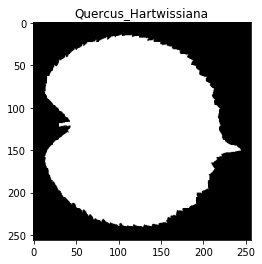

In [12]:
# Display a sample image
import matplotlib.pyplot as plt


plt.imshow(1-train_images[3,:,:,0],cmap='Greys')
plt.title(y_train[3])
plt.show()

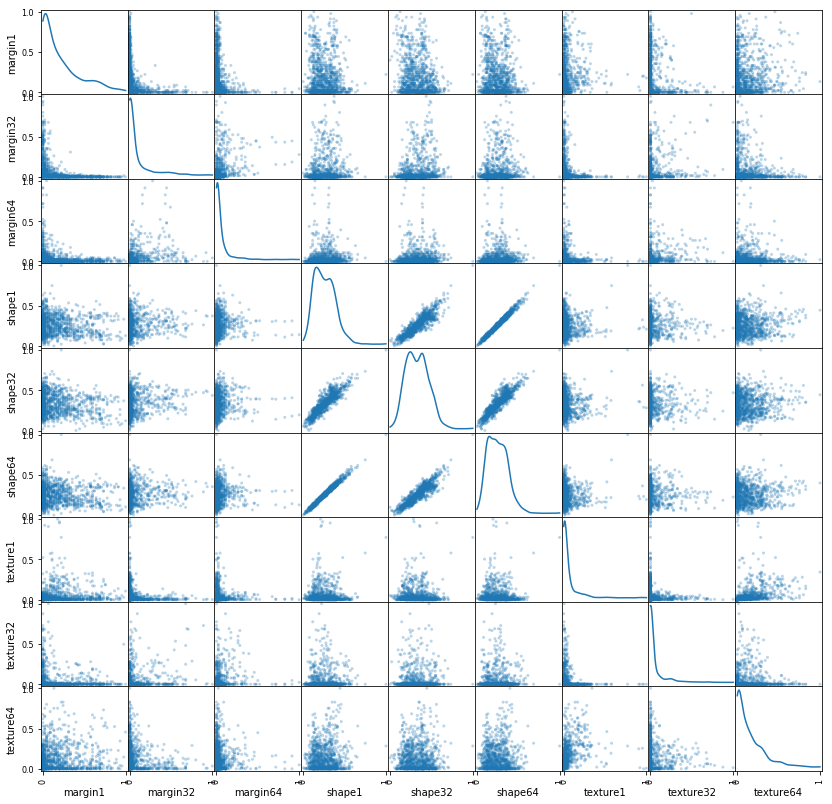

In [13]:
# Constructing a scatter plot for a sample of nine features

X_train_eda = pd.DataFrame(X_train[['margin1','margin32','margin64','shape1','shape32','shape64','texture1','texture32','texture64']])

pd.plotting.scatter_matrix(X_train_eda, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

1     0.227671
2     0.366516
3     0.427271
4     0.487533
5     0.530399
6     0.569413
7     0.604153
8     0.631987
9     0.655624
10    0.673711
11    0.691072
12    0.707747
13    0.723133
14    0.737339
15    0.748845
16    0.760082
17    0.770560
18    0.780021
19    0.789238
20    0.797641
21    0.805419
22    0.812648
23    0.819791
24    0.826371
25    0.832524
26    0.838257
27    0.843672
28    0.848929
29    0.854039
30    0.858645
Name: Explained Variance for number of components, dtype: float64

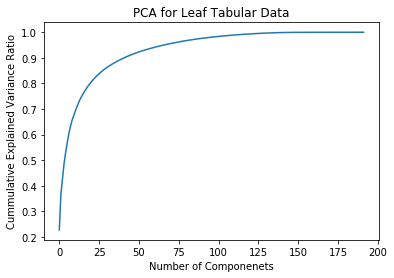

In [14]:
# Analyzing dimnesionality reduction effect on the tabular source training data
n_components = 192
pca = PCA(n_components=n_components,random_state=random_state).fit(X_train)

X_train_pca = pca.transform(X_train)

#pca = PCA(n_components=n_components,random_state=random_state).fit(X_train2)

#X_train2_pca = pca.transform(X_train2)

#pca = PCA(n_components=n_components,random_state=random_state).fit(X_val)

#X_val_pca = pca.transform(X_val)

#pca = PCA(n_components=n_components,random_state=random_state).fit(X_test)

#X_test_pca = pca.transform(X_test)

explained_variance = pd.Series(pca.explained_variance_ratio_.cumsum(),
          index=np.arange(1,n_components+1),
         name="Explained Variance for number of components")

display(explained_variance[:30])

plt.plot(pca.explained_variance_ratio_.cumsum());
plt.xlabel("Number of Componenets");
plt.ylabel("Cummulative Explained Variance Ratio");
plt.title("PCA for Leaf Tabular Data");

## Testing the performance of different classifier algorithms on the tabular data:

## 1- Decision Trees

In [15]:
accuracy_scores = np.zeros(5)
log_loss_train_scores = np.zeros(5)
log_loss_test_scores = np.zeros(5)

In [16]:
clf = DecisionTreeClassifier(random_state= random_state)

parameters = {'max_depth' : [ 10,30,35], 'max_features' : [25,35,40], 'min_samples_split' : [3,5,6]}

scorer = make_scorer(accuracy_score)

skf = StratifiedKFold(n_splits = 5)

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer, cv = skf)

grid_fit = grid_obj.fit(X_train,y_train)

best_clf = grid_fit.best_estimator_

predictions = best_clf.predict(X_train)
print("Accuracy Score on training data:", accuracy_score(predictions,y_train))
accuracy_scores[0] = accuracy_score(predictions,y_train)

predictions = best_clf.predict_proba(X_train)
print("Log Loss Score on training data:", log_loss(pd.get_dummies(y_train).values,predictions))
log_loss_train_scores[0]= log_loss(pd.get_dummies(y_train).values,predictions)

Accuracy Score on training data: 0.962626262626
Log Loss Score on training data: 0.0658413505449


In [17]:
# Getting log loss score on test data
predictions = best_clf.predict_proba(X_test)

submission = pd.DataFrame(predictions,index=X_test.index,columns=best_clf.classes_)

submission.to_csv(r'submission_DT.csv')

# Getting the multi-class log-loss from Kaggle submission
log_loss_DT = 14.75

print("Log loss score on testing data:", log_loss_DT)

Log loss score on testing data: 14.75


In [18]:
print("The best Decision Tree Classifier had the following parameters:")
print()
print(best_clf)

The best Decision Tree Classifier had the following parameters:

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
            max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')


## 2- AdaBoost


In [19]:
clf = AdaBoostClassifier(random_state= random_state)

parameters = {'n_estimators' : [90,100,150,200], 'learning_rate' : [.001, .01, .1]}

scorer = make_scorer(accuracy_score)

skf = StratifiedKFold(n_splits = 5)

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer, cv = skf)

grid_fit = grid_obj.fit(X_train,y_train)

best_clf = grid_fit.best_estimator_

predictions = best_clf.predict(X_train)
accuracy_scores[1] = accuracy_score(predictions,y_train)
print("Accuracy Score on training data:", accuracy_scores[1])


predictions = best_clf.predict_proba(X_train)
log_loss_train_scores[1]= log_loss(pd.get_dummies(y_train).values,predictions)
print("Log Loss Score on training data:", log_loss_train_scores[1])


Accuracy Score on training data: 0.616161616162
Log Loss Score on training data: 2.0899938625


In [20]:
# Getting log loss score on test data
predictions = best_clf.predict_proba(X_test)

submission = pd.DataFrame(predictions,index=X_test.index,columns=best_clf.classes_)

submission.to_csv(r'submission_Ada.csv')

log_loss_Ada = 2.5

print("Log loss score on testing data:", log_loss_Ada)

Log loss score on testing data: 2.5


In [21]:
print("The best AdaBoost Classifier had the following parameters:")
print()
print(best_clf)

The best AdaBoost Classifier had the following parameters:

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.01, n_estimators=150, random_state=123)


## 3- Support Vector Machines


In [22]:
clf = SVC(random_state= random_state,probability=True)

parameters = {'C' : [1,10,50], 'gamma' : [.01,0.1]}

scorer = make_scorer(accuracy_score)

skf = StratifiedKFold(n_splits = 5)

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer, cv = skf)

grid_fit = grid_obj.fit(X_train,y_train)

best_clf = grid_fit.best_estimator_

predictions = best_clf.predict(X_train)
accuracy_scores[2] = accuracy_score(predictions,y_train)
print("Accuracy Score on training data:", accuracy_scores[2])

predictions = best_clf.predict_proba(X_train)
log_loss_train_scores[2]= log_loss(pd.get_dummies(y_train).values,predictions)
print("Log Loss Score on training data:", log_loss_train_scores[2])

Accuracy Score on training data: 1.0
Log Loss Score on training data: 1.96785374076


In [23]:
# Getting log loss score on test data
predictions = best_clf.predict_proba(X_test)

submission = pd.DataFrame(predictions,index=X_test.index,columns=best_clf.classes_)

submission.to_csv(r'submission_SVC.csv')

log_loss_SVC = 1.99

print("Log loss score on testing data:", log_loss_SVC)

Log loss score on testing data: 1.99


In [24]:
print("The best SVM Classifier had the following parameters:")
print()
print(best_clf)

The best SVM Classifier had the following parameters:

SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=123, shrinking=True,
  tol=0.001, verbose=False)


## 4- K-Nearest Neighbors

In [25]:
clf = KNeighborsClassifier()

parameters = {'n_neighbors' : [3,5,10],'leaf_size': [5,10,20]}

scorer = make_scorer(accuracy_score)

skf = StratifiedKFold(n_splits = 5)

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer, cv = skf)

grid_fit = grid_obj.fit(X_train,y_train)

best_clf = grid_fit.best_estimator_




predictions = best_clf.predict(X_train)
accuracy_scores[3] = accuracy_score(predictions,y_train)
print("Accuracy Score on training data:", accuracy_scores[3])

predictions = best_clf.predict_proba(X_train)
log_loss_train_scores[3]= log_loss(pd.get_dummies(y_train).values,predictions)
print("Log Loss Score on training data:", log_loss_train_scores[3])

Accuracy Score on training data: 0.988888888889
Log Loss Score on training data: 0.0476985030164


In [26]:
# Getting log loss score on test data
predictions = best_clf.predict_proba(X_test)

submission = pd.DataFrame(predictions,index=X_test.index,columns=best_clf.classes_)

submission.to_csv(r'submission_KNN.csv')

log_loss_KNN = 0.14

print("Log loss score on testing data:", log_loss_KNN)

Log loss score on testing data: 0.14


In [27]:
print("The best KNN Classifier had the following parameters:")
print()
print(best_clf)

The best KNN Classifier had the following parameters:

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


## Testing the performance of different classifier algorithms on image data

In [28]:
#train3_images = np.reshape(train_images,(990,256*256))
#test3_images = np.reshape(test_images,(594,256*256))



#clf = MLPClassifier(hidden_layer_sizes=(100,100),max_iter=200,random_state=random_state)

#parameters = {'learning_rate_init' : [.001],'activation':['relu']}

#scorer = make_scorer(accuracy_score)

#skf = StratifiedKFold(n_splits = 5)

#grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer, cv = skf)

#grid_fit = grid_obj.fit(train3_images,y_train)

#best_clf = grid_fit.best_estimator_

#predictions = best_clf.predict(train3_images)
#accuracy_score(predictions,y_train)


In [29]:
#predictions = best_clf.predict_proba(X_test)

#submission = pd.DataFrame(predictions,index=X_test.index,columns=best_clf.classes_)

#submission.to_csv(r'submission_MLP.csv')

#best_clf

## Convolutional Neural Network Implementation on image data alone

In [30]:
# Loading keras packages 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,Activation
from keras.layers import Dropout, Flatten, Dense, Add,BatchNormalization,Merge
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint 

In [31]:
# Defining keras model
model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2,strides=2, padding='same', activation='tanh', 
                        input_shape=train2_images.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=32, kernel_size=2,strides=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=64, kernel_size=2,strides=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(200, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(99, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
__________

In [32]:
#Defining the optimizer and compiling the model
optimizer = RMSprop(lr=.001, rho=0.9, epsilon=1e-08, decay=0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [33]:
# Number of epochs to run
epochs = 2000

# Saving best model
checkpointer = ModelCheckpoint(filepath='weights.best1.hdf5', 
                               verbose=1, save_best_only=True)

# Fitting the model
model.fit(train2_images, pd.get_dummies(y_train2).values, 
          validation_data=(val_images, pd.get_dummies(y_val).values),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 792 samples, validate on 198 samples
Epoch 1/2000
792/792 [==============================] - 4s 6ms/step - loss: 4.7792 - acc: 0.0076 - val_loss: 4.5806 - val_acc: 0.0101
Epoch 2/2000
792/792 [==============================] - 1s 949us/step - loss: 4.6603 - acc: 0.0177 - val_loss: 4.5590 - val_acc: 0.0253
Epoch 3/2000
792/792 [==============================] - 1s 954us/step - loss: 4.6095 - acc: 0.0164 - val_loss: 4.5410 - val_acc: 0.0404
Epoch 4/2000
792/792 [==============================] - 1s 946us/step - loss: 4.5547 - acc: 0.0189 - val_loss: 4.5137 - val_acc: 0.0455
Epoch 5/2000
792/792 [==============================] - 1s 951us/step - loss: 4.5402 - acc: 0.0253 - val_loss: 4.4635 - val_acc: 0.0707
Epoch 6/2000
792/792 [==============================] - 1s 949us/step - loss: 4.4491 - acc: 0.0354 - val_loss: 4.3847 - val_acc: 0.0960
Epoch 7/2000
792/792 [==============================] - 1s 949us/step - loss: 4.3424 - acc: 0.0619 - val_loss: 4.2417 - val_acc: 0.1061
Epoc

In [34]:
# loading best model
model.load_weights('weights.best1.hdf5')

predictions = model.predict_classes(train_images)

accuracy_scores[4] = accuracy_score(pd.get_dummies(y_train).columns[predictions],y_train)
print("Accuracy Score on training data:", accuracy_scores[4])

predictions = model.predict_proba(train_images)

log_loss_train_scores[4]= log_loss(pd.get_dummies(y_train).values,predictions)
print("Log Loss Score on training data:", log_loss_train_scores[4])

predictions= model.predict_proba([test_images])


submission = pd.DataFrame(predictions,index=X_test.index,columns=pd.get_dummies(y_val).columns)

submission.to_csv(r'submission_CNN1.csv')

log_loss_CNN1 = 1.79
print("Log loss score on testing data:", log_loss_CNN1)



990/990 [==============================] - 0s 339us/step
Accuracy Score on training data: 0.916161616162
990/990 [==============================] - 0s 318us/step
Log Loss Score on training data: 0.351756336024
594/594 [==============================] - 0s 333us/step
Log loss score on testing data: 1.79


## Summarizing results for the benchmark models

In [35]:
# Saving the log-loss metric in the new array 
log_loss_test_scores[0] = log_loss_DT
log_loss_test_scores[1] = log_loss_Ada
log_loss_test_scores[2] = log_loss_SVC
log_loss_test_scores[3] = log_loss_KNN
log_loss_test_scores[4] = log_loss_CNN1
metrics = np.vstack([accuracy_scores*100,log_loss_train_scores,log_loss_test_scores]).T
result_df = pd.DataFrame(metrics,index=["DT","Ada","SVC","KNN","CNN1"],columns=["accuracy","log loss train","log loss test"])
display(result_df)

,accuracy,log loss train,log loss test
DT,96.262626,0.065841,14.75
Ada,61.616162,2.089994,2.50
SVC,100.000000,1.967854,1.99
KNN,98.888889,0.047699,0.14
CNN1,91.616162,0.351756,1.79


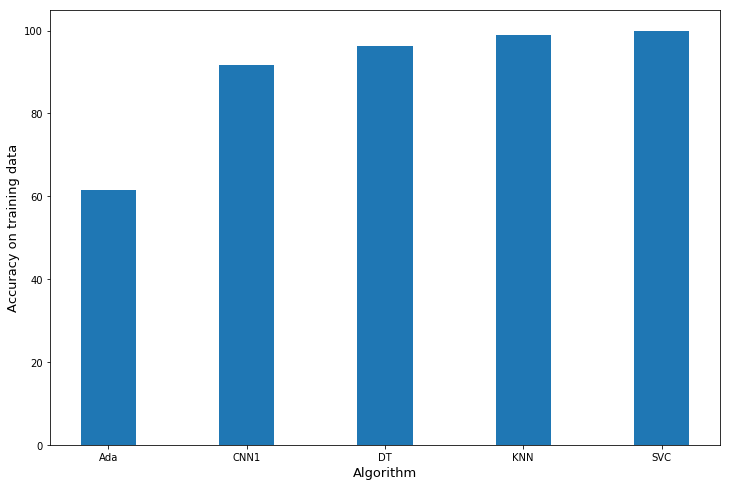

In [36]:
plt.figure(figsize=(12,8))
plt.bar(result_df.index,result_df["accuracy"],width=.4);
plt.xlabel('Algorithm',size=13);
plt.ylabel('Accuracy on training data',size=13);

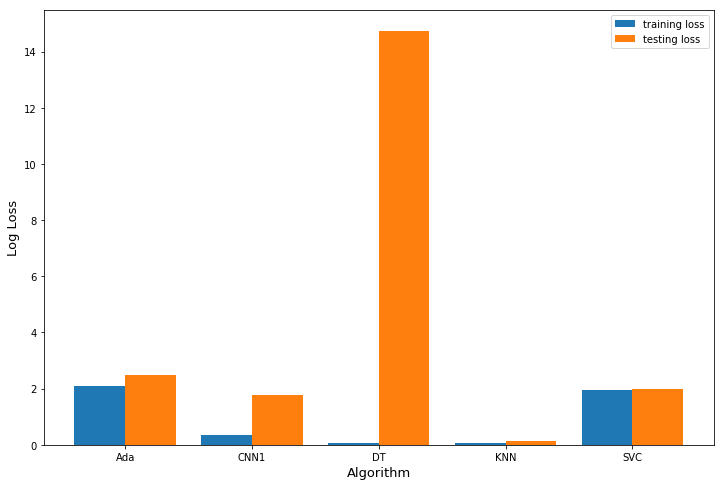

In [37]:
plt.figure(figsize=(12,8));
plt.bar(result_df.index,result_df["log loss train"],align='edge',width=-.4,label='training loss');
plt.bar(result_df.index,result_df["log loss test"],align='edge',width=.4,label='testing loss');
plt.xlabel('Algorithm',size=13);
plt.ylabel('Log Loss',size=13);
plt.legend();

## Final Model
## Convolutional Neural Network using both tabular and image data

In [41]:
model1 = Sequential()

### TODO: Define your architecture.
model1.add(Conv2D(filters=16, kernel_size=2,strides=2, padding='same', activation='tanh', 
                        input_shape=train2_images.shape[1:]))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.5))
model1.add(Conv2D(filters=32, kernel_size=2,strides=2, padding='same', activation='tanh'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.5))
model1.add(Conv2D(filters=64, kernel_size=2,strides=2, padding='same', activation='tanh'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.5))
#model.add(GlobalAveragePooling2D())
model1.add(Flatten())
#model.add(Dropout(0.5))
model1.add(Dense(99, activation='tanh'))

model1.summary()

model2 = Sequential()
model2.add(Dense(200, input_shape = X_train2.shape[1:]))
model2.add(BatchNormalization())
model2.add(Activation('tanh'))
model2.add(Dropout(0.5))

model2.summary()

model = Sequential()
model.add(Merge([model1,model2],mode='concat',concat_axis=1))
model.add(Dense(200))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(99, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 16)      80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          8256      
__________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [42]:
optimizer = RMSprop(lr=.001, rho=0.9, epsilon=1e-08, decay=0)
#RMSprop?
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:

epochs = 2000

checkpointer = ModelCheckpoint(filepath='weights.best2.hdf5', 
                               verbose=1, save_best_only=True)

model.fit([train2_images,X_train2], pd.get_dummies(y_train2).values, 
          validation_data=([val_images,X_val], pd.get_dummies(y_val).values),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 792 samples, validate on 198 samples
Epoch 1/2000
792/792 [==============================] - 1s 2ms/step - loss: 4.5363 - acc: 0.0455 - val_loss: 4.1910 - val_acc: 0.1313
Epoch 2/2000
792/792 [==============================] - 1s 1ms/step - loss: 3.4317 - acc: 0.2134 - val_loss: 3.8317 - val_acc: 0.3333
Epoch 3/2000
792/792 [==============================] - 1s 1ms/step - loss: 2.8595 - acc: 0.3687 - val_loss: 3.4517 - val_acc: 0.6111
Epoch 4/2000
792/792 [==============================] - 1s 1ms/step - loss: 2.3163 - acc: 0.5518 - val_loss: 3.0457 - val_acc: 0.7879
Epoch 5/2000
792/792 [==============================] - 1s 1ms/step - loss: 1.9043 - acc: 0.6553 - val_loss: 2.6277 - val_acc: 0.8788
Epoch 6/2000
792/792 [==============================] - 1s 1ms/step - loss: 1.6486 - acc: 0.7020 - val_loss: 2.2189 - val_acc: 0.9343
Epoch 7/2000
792/792 [==============================] - 1s 1ms/step - loss: 1.3088 - acc: 0.8295 - val_loss: 1.8096 - val_acc: 0.9697
Epoch 8/2000
792

In [49]:
model.load_weights('weights.best2.hdf5')

predictions= model.predict_classes([train_images,X_train])

best_accuracy_score = accuracy_score(pd.get_dummies(y_train).columns[predictions],y_train)

print("Accuracy Score on training data:", best_accuracy_score)

predictions= model.predict_proba([train_images,X_train])

best_log_loss_train_score= log_loss(pd.get_dummies(y_train).values,predictions)

print("Log Loss Score on training data:", best_log_loss_train_score)

predictions= model.predict_proba([test_images,X_test])
#predictions.shape

#model.
submission = pd.DataFrame(predictions,index=X_test.index,columns=pd.get_dummies(y_val).columns)

submission.to_csv(r'submission_CNN2.csv')
#.619 300 epochs
#.219 1000 epochs
#.183 2000 epochs

# 1600 epochs with scaling
# loading best model


log_loss_CNN2 = .05
print("Log loss score on testing data:", log_loss_CNN2)

990/990 [==============================] - 0s 380us/step
Accuracy Score on training data: 1.0
990/990 [==============================] - 0s 378us/step
Log Loss Score on training data: 7.2845228741e-06
594/594 [==============================] - 0s 363us/step
Log loss score on testing data: 0.05


198/198 [==============================] - 0s 435us/step


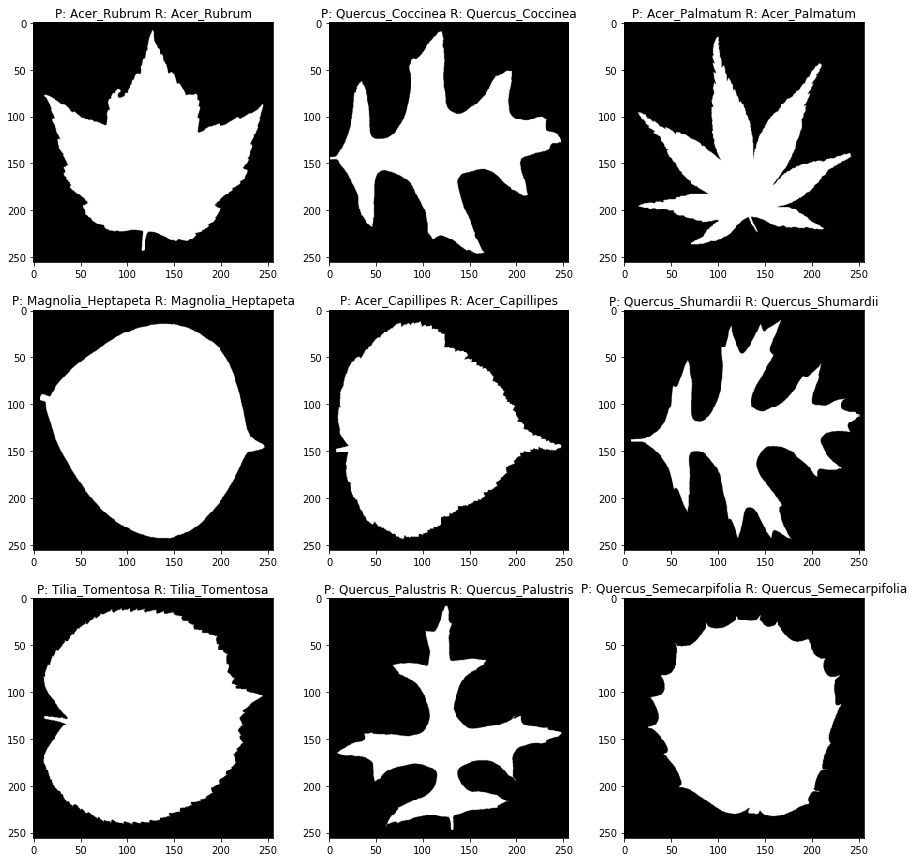

In [69]:
predictions= model.predict_classes([val_images,X_val])

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(1-val_images[i,:,:,0],cmap='Greys')
    plt.title("P: "+pd.get_dummies(y_val).columns[predictions][i]+" R: "+y_val.iloc[i])

plt.show()